# **SPRINT 1 – Geração do Dataset e Treinamento do Modelo**

Integrantes do grupo:
* Danilo Ramalho Silva | RM: 555183
* Israel Dalcin Alves Diniz | RM: 554668
* João Vitor Pires da Silva | RM: 556213
* Matheus Hungaro | RM: 555677
* Pablo Menezes Barreto | RM: 556389
* Tiago Toshio Kumagai Gibo | 556984


## 1 - Instalação dos pacotes

In [1]:
!pip install tensorflow==2.10.0 numpy==1.24.3 scikit-learn==1.3.0 matplotlib==3.7.1 seaborn==0.12.2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.10.0


## 2 - Importes e configuraçoes iniciais

In [2]:
import os
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report
)

# Diretório onde estão as pastas de imagens organizadas por classe
DATA_DIR = '/content/dataset'
# Tamanho para redimensionar todas as imagens (altura, largura)
IMG_SIZE = (224, 224)
# Número de imagens por batch
BATCH_SIZE = 16
# Quantas épocas treinar
EPOCHS = 10
# Percentual de validação (ex.: 0.2 = 20% das imagens vão para validação)
VALIDATION_SPLIT = 0.2

## 3 - Função do Modelo CNN

In [15]:
def create_cnn_model(input_shape=(224, 224, 3),
                     num_classes=None,
                     class_names=None):
    """
    Cria e compila uma CNN simples.
    - Se num_classes não for informado, calcula a partir de class_names.
    - Entrada: imagens de tamanho input_shape.
    - Saída: probabilidade (softmax) para cada classe.
    """
    # Determina número de classes
    if num_classes is None:
        if class_names is None:
            raise ValueError("Informe num_classes ou class_names")
        num_classes = len(class_names)

    model = models.Sequential([
        # Camada de entrada com shape definido
        layers.Input(shape=input_shape),

        # Bloco convolucional 32 filtros
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloco convolucional 64 filtros
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Bloco convolucional 128 filtros
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Achata mapas de ativação em vetor
        layers.Flatten(),

        # Fully-connected de 64 neurônios
        layers.Dense(64, activation='relu'),

        # Camada de saída com softmax para cada classe
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compila com otimizador Adam e loss apropriada para rótulos inteiros
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 4 - Função de treino e separação dos dados de treino e teste

In [4]:
def load_dataset(data_dir=DATA_DIR,
                 img_size=IMG_SIZE,
                 batch_size=BATCH_SIZE,
                 validation_split=VALIDATION_SPLIT):
    """
    Carrega imagens de pastas com structure:
        DATA_DIR/
            ClasseA/...
            ClasseB/...
    e retorna:
    - train_ds: dataset de treinamento com cache e shuffle
    - val_ds: dataset de validação com cache
    - class_names: lista de nomes de pastas (classes)
    """
    # 1) Carrega as imagens sem cache/prefetch para extrair class_names
    train_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )
    val_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    # 2) Captura a lista de classes (nomes das pastas)
    class_names = train_raw.class_names

    # 3) Aplica cache, shuffle (só no treino) e prefetch para performance
    autotune = tf.data.AUTOTUNE
    train_ds = train_raw.cache().shuffle(1000).prefetch(buffer_size=autotune)
    val_ds = val_raw.cache().prefetch(buffer_size=autotune)

    return train_ds, val_ds, class_names


def train(model, train_ds, val_ds, epochs=EPOCHS):
    """
    Executa o treinamento do modelo.
    - train_ds: dataset de treino
    - val_ds: dataset de validação
    - epochs: quantas eras de treino
    Retorna o objeto History com métricas por época.
    """
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds
    )
    return history


## 5 - Funçoes para plotar os graficos

In [5]:
def plot_history(history):
    """
    Plota gráficos de accuracy e loss ao longo das épocas.
    - history: objeto retornado por model.fit()
    """
    # Gráfico de acurácia
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='treino')
    plt.plot(history.history['val_accuracy'], label='validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='treino')
    plt.plot(history.history['val_loss'], label='validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confusion(model, val_ds, class_names):
    """
    Constrói e exibe a matriz de confusão.
    - model: modelo já treinado
    - val_ds: dataset de validação
    - class_names: lista de labels para os eixos
    """
    # Extrai todos os rótulos verdadeiros
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    # Gera probabilidades e converte para índice de classe
    y_prob = model.predict(val_ds)
    y_pred = np.argmax(y_prob, axis=1)

    # Garante matriz quadrada incluindo todas as classes
    all_labels = np.arange(len(class_names))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusão')
    plt.show()


def plot_roc(model, val_ds):
    """
    Plota a Curva ROC e exibe a AUC.
    - Considera a segunda coluna de y_prob como "classe positiva".
    """
    # Rótulos e probabilidades
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    y_prob = model.predict(val_ds)[:, 1]

    # Calcula pontos da curva e AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Desenha gráfico
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], '--', label='Aleatório')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


def plot_pr_curve(model, val_ds):
    """
    Plota a Curva Precision-Recall e exibe o Average Precision (AP).
    """
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    y_prob = model.predict(val_ds)[:, 1]

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'AP = {ap:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


def plot_classification_report(model, val_ds, class_names):
    """
    Gera bar plot com Precision, Recall e F1-score por classe.
    """
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    y_pred = np.argmax(model.predict(val_ds), axis=1)

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Extrai as métricas para cada classe
    precisions = [report[c]['precision'] for c in class_names]
    recalls = [report[c]['recall'] for c in class_names]
    f1s = [report[c]['f1-score'] for c in class_names]

    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(8, 4))
    plt.bar(x - width, precisions, width, label='Precision')
    plt.bar(x, recalls, width, label='Recall')
    plt.bar(x + width, f1s, width, label='F1-score')
    plt.xticks(x, class_names)
    plt.ylabel('Score')
    plt.title('Métricas por Classe')
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

## 6 - Função axiliar para criar o repositorio

In [7]:
def create_dataset_folders(base_dir='/content/dataset'):
    """
    Cria a estrutura de pastas para o dataset:
    base_dir/
        HP_original/
        outros/
    """
    hp_dir = os.path.join(base_dir, 'HP_original')
    outros_dir = os.path.join(base_dir, 'outros')

    os.makedirs(hp_dir, exist_ok=True)
    os.makedirs(outros_dir, exist_ok=True)

    print(f"Pastas criadas em: {base_dir}")
    print(f"- {hp_dir}")
    print(f"- {outros_dir}")

In [8]:
#create_dataset_folders()

Pastas criadas em: /content/dataset
- /content/dataset/HP_original
- /content/dataset/outros


## 7 - Carrega os dados, cria, treina e salva o model

In [9]:
# 1) Carrega datasets e nomes de classe
train_ds, val_ds, class_names = load_dataset()

# 2) Cria a CNN definida para 2 classes
model = create_cnn_model(num_classes=2)

# 3) Treina o modelo
history = train(model, train_ds, val_ds)

# 4) Salva o modelo em disco
model.save('hp_classifier.h5')
print(' ')
print('Modelo salvo em hp_classifier.h5')


Found 60 files belonging to 2 classes.
Using 48 files for training.
Found 60 files belonging to 2 classes.
Using 12 files for validation.
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4453 - loss: 1145.6041 - val_accuracy: 0.4167 - val_loss: 203.5281
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4870 - loss: 150.7110 - val_accuracy: 0.4167 - val_loss: 4.5561
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6224 - loss: 7.9676 - val_accuracy: 0.8333 - val_loss: 1.1804
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.7760 - loss: 1.1005 - val_accuracy: 0.5833 - val_loss: 2.2603
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6198 - loss: 2.0344 - val_accuracy: 0.8333 - val_loss: 0.3109
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8490 - loss: 0.4744 - val_accuracy: 0.7500 - val_loss: 0.6355
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8594 - loss: 0.4156 - val_accuracy: 0.9167 - val_loss: 

 
Modelo salvo em hp_classifier.h5


## 8 - Gráficos de performance

### 8.1 Curvas de Treino × Validação

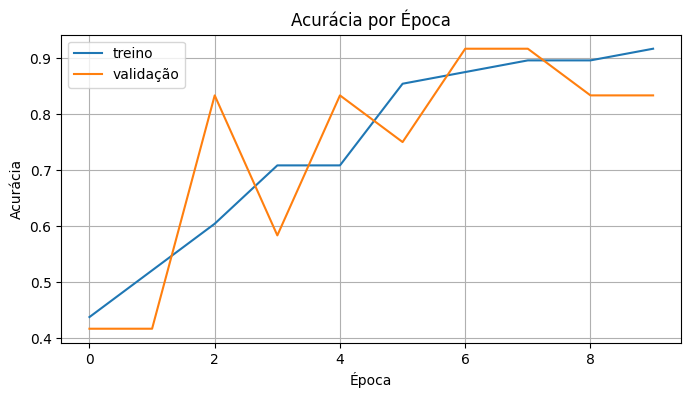

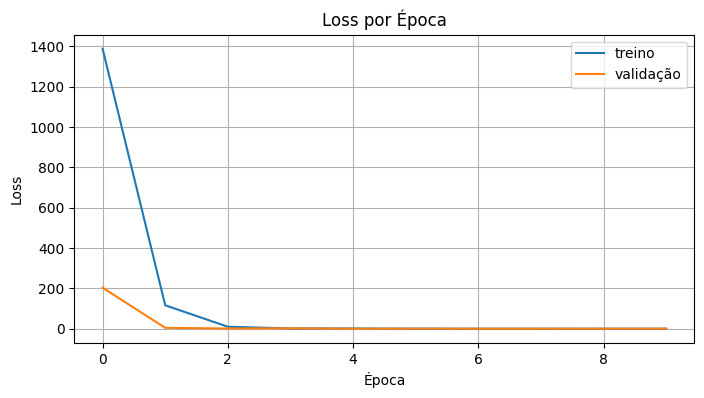

In [10]:
plot_history(history)                       # plota curvas

**Loss:** Treino cai de ≈1400 (época 0) para ≈10 (época 2) e chega quase a zero já na época 3.
Validação inicia em ≈200, acompanha a queda e estabiliza próximo de zero.   
**Acurácia:** Treino sobe de 44% para 92% em 10 épocas.
Validação oscila: 42% (ép 0–1) → 83% (ép 2) → 58% (ép 3) → picos de 92% (ép 6–7) → encerra em ~83%.


### 8.2 - Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


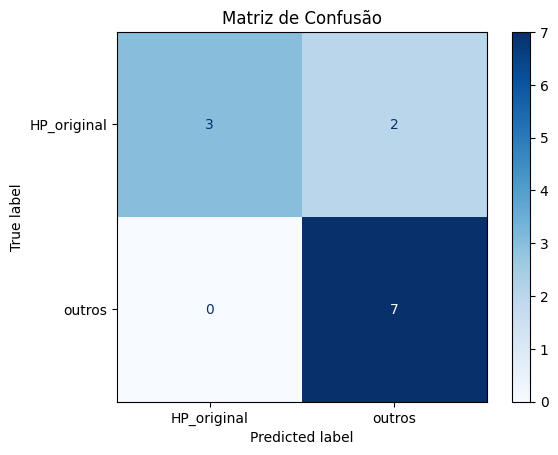

In [11]:
# agora funciona sem erro
plot_confusion(model, val_ds, class_names)

**HP_original:** recall 3/5 = 60%, precision 3/3 = 100%
**outros:** recall 7/7 = 100%, precision 7/9 ≈ 78%
**Comentário:** o modelo nunca classifica “outros” como “original” (nenhum falso positivo em HP_original), mas perde 40% dos originais.

### 8.3 - Curva ROC

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


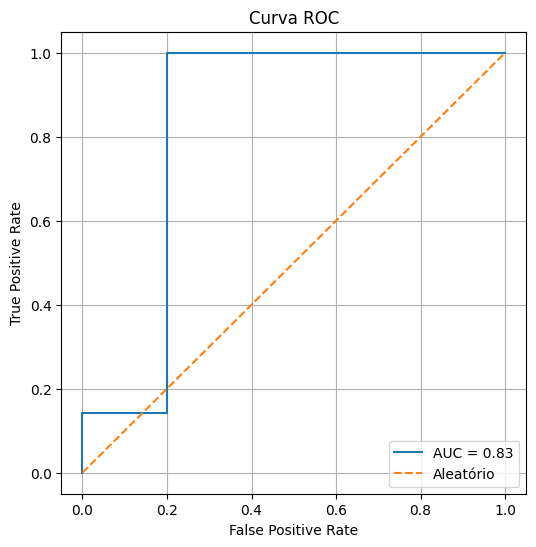

In [12]:
plot_roc(model, val_ds)


AUC = 0,83
A TPR atinge 100% já com FPR ≈20%.
**Comentário:** discriminação boa (AUC≪0,5 = acaso), mas salto brusco reflete thresholds discretos e poucos dados.

### 8.4 - Curva Precision-Recall

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


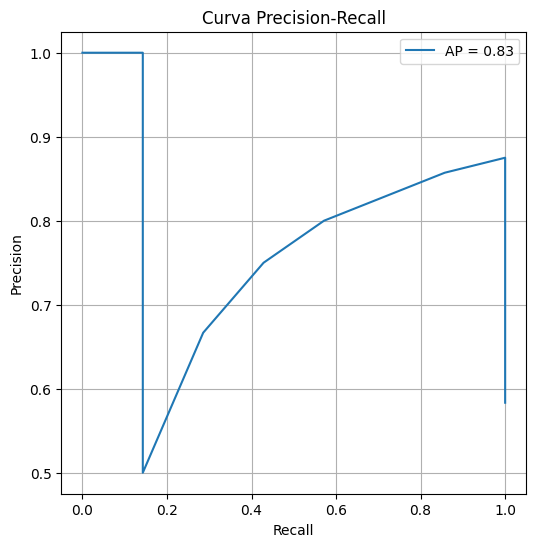

In [13]:
plot_pr_curve(model, val_ds)

AP = 0,83
Precisão máxima (1,0) em recalls muito baixos; cai para 0,50 em recall ≈0,15; recupera-se para ~0,75–0,85 em recall 0,4–0,8; em recall=1,0, precisão ≈0,58.
**Comentário:** bom equilíbrio geral, mas exige escolher threshold intermediário (recall≈0,4–0,8) para manter precisão elevada sem descartar muitos positivos.

### 8.5 - Métricas por Classe (Precision / Recall / F1-score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


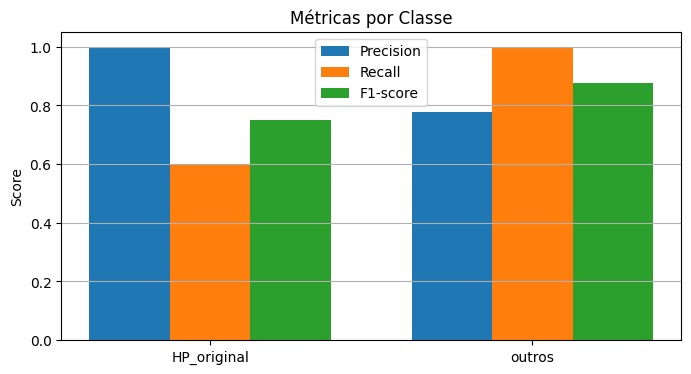

In [14]:
plot_classification_report(model, val_ds, class_names)


**Comentário:** “HP_original” tem precisão perfeita mas recall baixo; “outros” recall perfeito mas aceita alguns originais como negativos.

## 9. Acurácia Final do Modelo

Validação: 83% (último valor de history.history['val_accuracy'])

## 5. Conclusão

O modelo simples aprendeu rapidamente a distinguir cartuchos originais vs. outros, atingindo 92% de treino e 83% de validação. Entretanto, a alta variância e os falsos negativos em “HP_original” (40%) indicam necessidade de:
*   Aumento dos dados (especialmente para a classe
original) ou coleta de mais imagens.
* Ajuste de limiar de decisão para equilibrar precisão e recall.
* Experimentar backbone pré-treinado leve (ex.: MobileNetV2) e comparar ganhos de performance.
